In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import tabulate
from os.path import join

RESULTS_DIR = "smartcomp-results"
HUE_ORDER = ["Federated", "Centralized", "Decentralized"]
STYLE_ORDER = ["Federated", "Centralized", "Decentralized"]
plt.style.use(["science", "ieee", "no-latex"])
warnings.simplefilter("ignore")

# Loading Testing/Evaluation Data

In [2]:
base_path = ("..", "out", "experiments", "smartcomp-digital")
replacements = {
    # Netfile names
    "grid-3x3": "Grid-3x3",
    "grid-5x5": "Grid-5x5",
    "grid-7x7": "Grid-7x7",

    # Trainer names
    "FedRL": "Federated",
    "MARL": "Decentralized",
    "SARL": "Centralized",

    # Extra
    "Timed-Phase": "Pre-Timed"
}

rewards_df = pd.read_csv(join(*base_path, "rewards.csv"))
rewards_df.replace(replacements, inplace=True)
rewards_df['trainer_intersection'] = rewards_df['trainer_intersection'].fillna("Pre-Timed")

trips_df = pd.read_csv(join(*base_path, "tripinfo.csv"))
trips_df.replace(replacements, inplace=True)
trips_df['trainer_intersection'] = trips_df['trainer_intersection'].fillna("Pre-Timed")

rewards_df.head()

,Unnamed: 0,tls_id,reward,netfile,step,n_vehicles,policy,trainer,trainer_intersection,trainer_ranked,mc_run
0,0,A0,-0.0,Grid-3x3,1,0,v4_naive-aggr_unranked.pkl,Federated,Grid-3x3,unranked,0
1,1,A1,-0.0,Grid-3x3,1,0,v4_naive-aggr_unranked.pkl,Federated,Grid-3x3,unranked,0
2,2,A2,-0.0,Grid-3x3,1,0,v4_naive-aggr_unranked.pkl,Federated,Grid-3x3,unranked,0
3,3,B0,-0.0,Grid-3x3,1,0,v4_naive-aggr_unranked.pkl,Federated,Grid-3x3,unranked,0
4,4,B1,-0.0,Grid-3x3,1,0,v4_naive-aggr_unranked.pkl,Federated,Grid-3x3,unranked,0


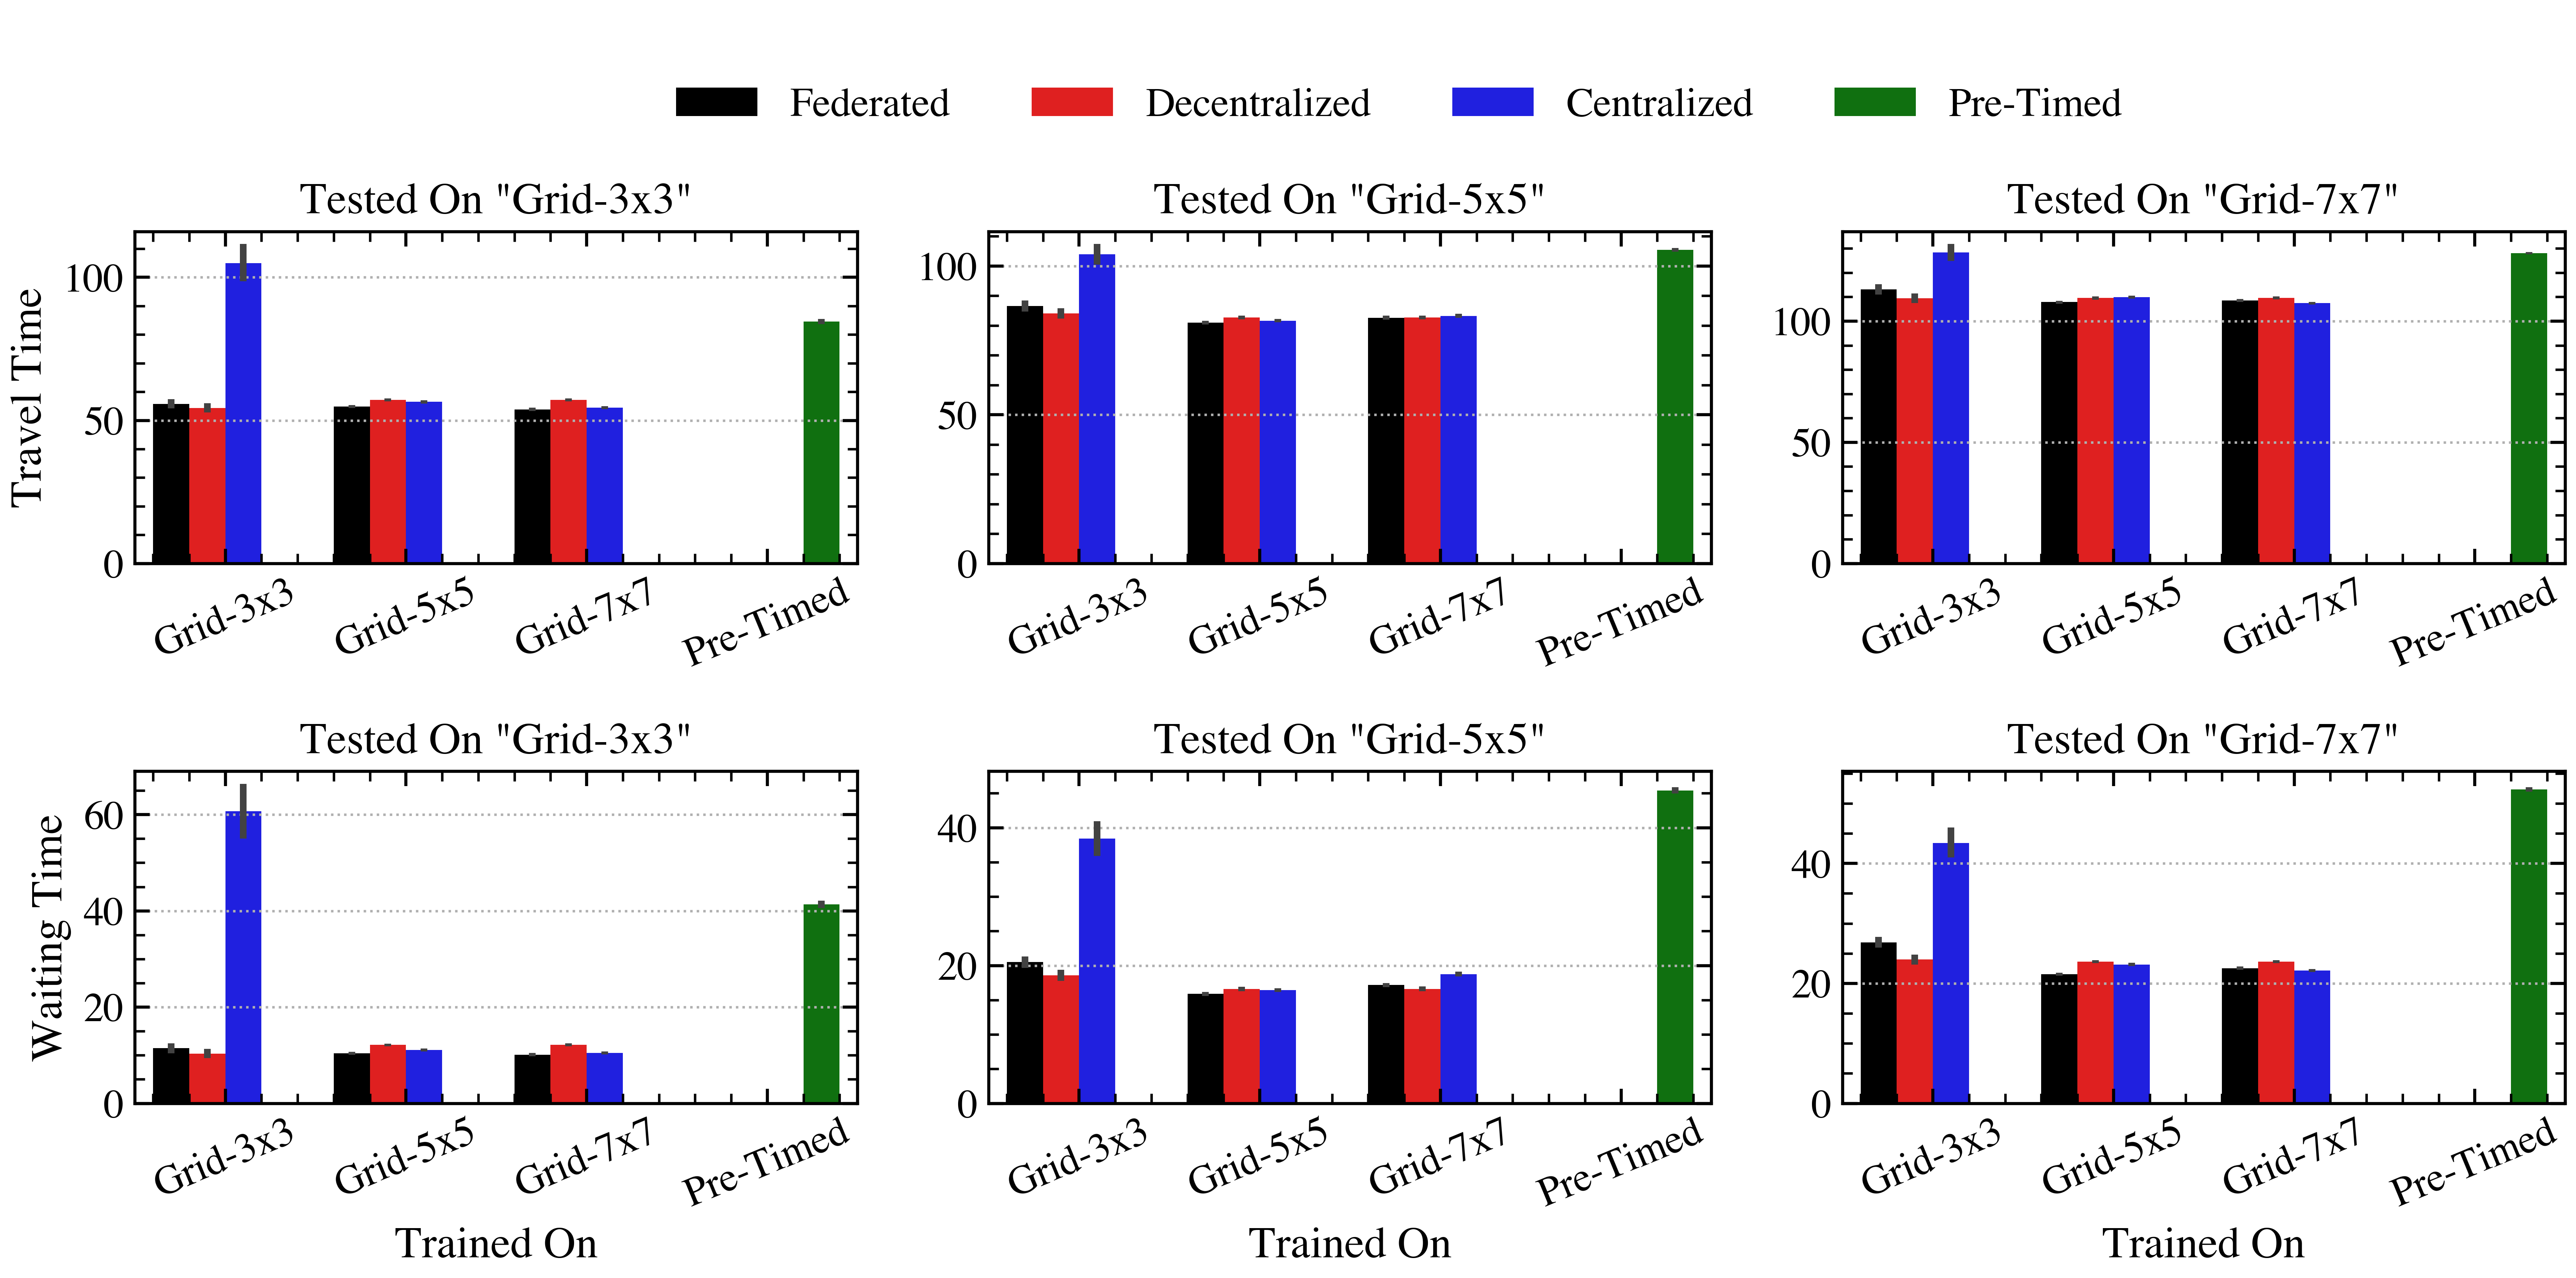

In [11]:
NETFILES = ['Grid-3x3', 'Grid-5x5', 'Grid-7x7']
METRICS = ['travel_time', 'waiting_time']

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(nrows=len(METRICS), ncols=len(NETFILES), figsize=(12, 6))
    for (i, metric) in enumerate(METRICS):
        for (j, train_inter) in enumerate(NETFILES):
            g = sns.barplot(
                data=trips_df.query(f'netfile == "{train_inter}" and trainer_ranked == "unranked"'),
                ax=ax[i,j],
                x='trainer_intersection',
                y=metric,
                hue='trainer'
            )#.set(yscale='log')
            ax[i, j].set_title(train_inter.title().replace('X', '$\\times$'))
            ax[i, j].grid(which='major', axis='y', linestyle='dotted')
            ax[i, j].set_xlabel('Trained On')
            ax[i, j].set_ylabel(metric.replace('_', ' ').title())
            ax[i, j].set_title(f'Tested On "{train_inter}"')

            h, l = ax[i, j].get_legend_handles_labels()
            ax[i, j].get_legend().remove()
            ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=22.5)

            if i != len(METRICS)-1:
                ax[i, j].set_xlabel('')
            if j != 0:
                ax[i, j].set_ylabel('')

    fig.legend(h, l, ncol=4, bbox_to_anchor=(0.825, 0.95), frameon=False)
    fig.suptitle('\n')
    plt.tight_layout()
    fig.savefig(join(RESULTS_DIR, f'evaluation-trips-metrics.pdf'))
    plt.show()

In [20]:
def percentage_change_decr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = benchmark.mean() - comparator.mean()
    return (change / benchmark.mean()) * 100

def percentage_change_incr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = comparator.mean() - benchmark.mean()
    return (change / benchmark.mean()) * 100

cen_travel_time = trips_df.query("trainer == 'Centralized'")["travel_time"].to_numpy()
dec_travel_time = trips_df.query("trainer == 'Decentralized'")["travel_time"].to_numpy()
fed_travel_time = trips_df.query("trainer == 'Federated'")["travel_time"].to_numpy()
timed_travel_time = trips_df.query("trainer == 'Pre-Timed'")["travel_time"].to_numpy()

cen_wait_time = trips_df.query("trainer == 'Centralized'")["waiting_time"].to_numpy()
dec_wait_time = trips_df.query("trainer == 'Decentralized'")["waiting_time"].to_numpy()
fed_wait_time = trips_df.query("trainer == 'Federated'")["waiting_time"].to_numpy()
timed_wait_time = trips_df.query("trainer == 'Pre-Timed'")["waiting_time"].to_numpy()

table = [
    ["Centralized   travel time reduction",  f"{percentage_change_decr(timed_travel_time, cen_travel_time):0.2f}%"],
    ["Decentralized travel time reduction",  f"{percentage_change_decr(timed_travel_time, dec_travel_time):0.2f}%"],
    ["Federated     travel time reduction",  f"{percentage_change_decr(timed_travel_time, fed_travel_time):0.2f}%"],

    ["Centralized   wait time reduction",    f"{percentage_change_decr(timed_wait_time, cen_wait_time):0.2f}%"],
    ["Decentralized wait time reduction",    f"{percentage_change_decr(timed_wait_time, dec_wait_time):0.2f}%"],
    ["Federated     wait time reduction",    f"{percentage_change_decr(timed_wait_time, fed_wait_time):0.2f}%"]
]
print(tabulate.tabulate(table, tablefmt="fancy_grid"))

╒═════════════════════════════════════╤════════╕
│ Centralized   travel time reduction │ 11.63% │
├─────────────────────────────────────┼────────┤
│ Decentralized travel time reduction │ 18.16% │
├─────────────────────────────────────┼────────┤
│ Federated     travel time reduction │ 18.14% │
├─────────────────────────────────────┼────────┤
│ Centralized   wait time reduction   │ 42.81% │
├─────────────────────────────────────┼────────┤
│ Decentralized wait time reduction   │ 58.92% │
├─────────────────────────────────────┼────────┤
│ Federated     wait time reduction   │ 58.93% │
╘═════════════════════════════════════╧════════╛


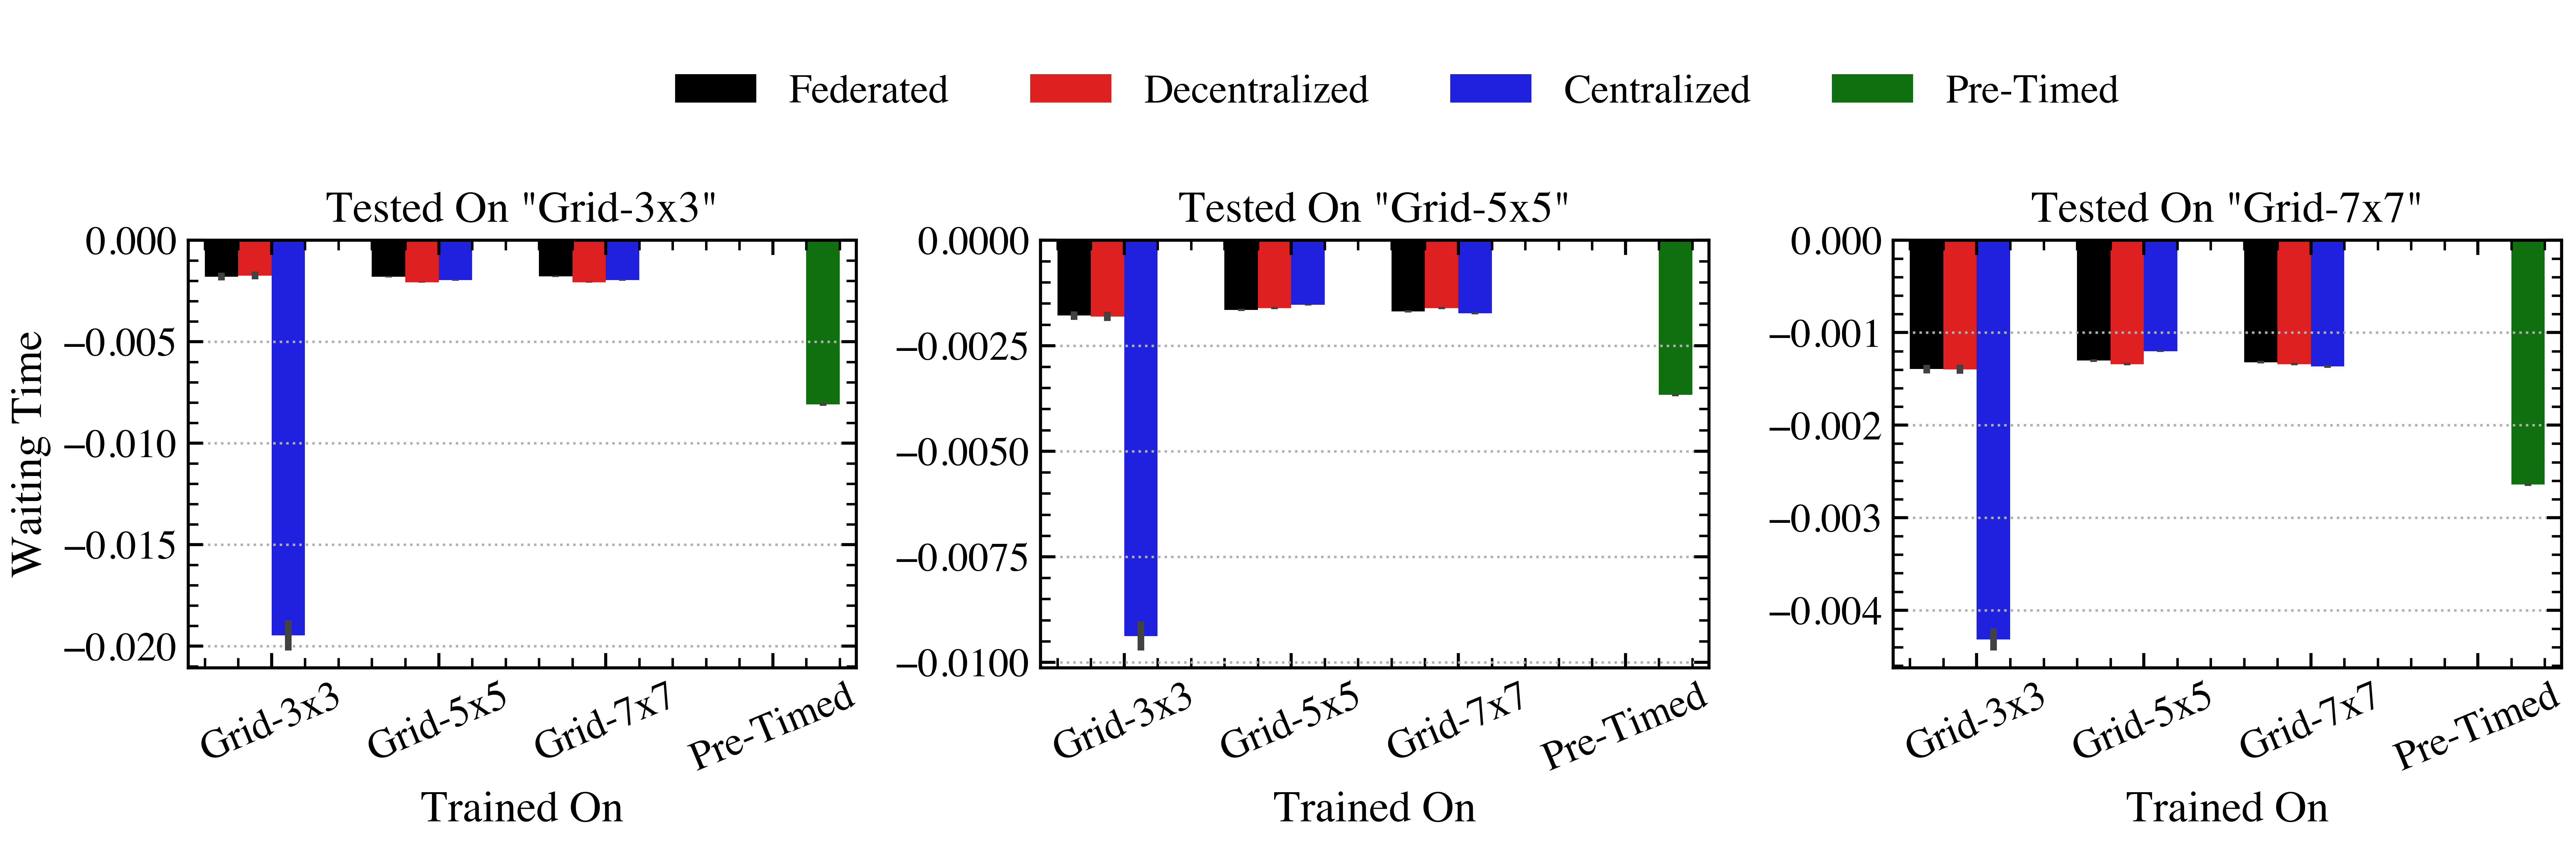

In [10]:
NETFILES = ['Grid-3x3', 'Grid-5x5', 'Grid-7x7']

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(nrows=1, ncols=len(NETFILES), figsize=(12, 4))
    for (i, train_inter) in enumerate(NETFILES):
        g = sns.barplot(
            data=rewards_df.query(f'netfile == "{train_inter}" and trainer_ranked == "unranked"'),
            ax=ax[i],
            x='trainer_intersection',
            y="reward",
            hue='trainer'
        )#.set(yscale='log')
        ax[i].set_title(train_inter.title().replace('X', '$\\times$'))
        ax[i].grid(which='major', axis='y', linestyle='dotted')
        ax[i].set_xlabel('Trained On')
        ax[i].set_ylabel("Reward")
        ax[i].set_title(f'Tested On "{train_inter}"')

        h, l = ax[i].get_legend_handles_labels()
        ax[i].get_legend().remove()
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=22.5)

        if i != 0:
            ax[i].set_ylabel('')

    fig.legend(h, l, ncol=4, bbox_to_anchor=(0.825, 0.95), frameon=False)
    fig.suptitle('\n')
    plt.tight_layout()
    fig.savefig(join(RESULTS_DIR, f'evaluation-trips-reward.pdf'))
    plt.show()